# Economic Value Added Model 

Economic Value Added (EVA) is a fundamental valuation framework that aims at estimating a firm's economic profit, or the value created in excess of the required return of the company's shareholders. EVA is the net profit less the capital charge for raising the firm's capital. The idea is that value is created when the return on the firm's economic capital employed exceeds the cost of that capital.

Sources:
- Best-Practice EVA: The Definitive Guide to Measuring and Maximizing Shareholder Value by G. Bennett Stewart

#### Read app key & import python packages 

In [1]:
import eikon as TR
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
TR.set_app_key('29e7c9361eb64e748246349dff7c07a532e1f41d')

#### Pull fundamental fields from Refinitiv Company Fundamentals (RCF)

In [2]:
Ndata, err= TR.get_data(['0#.SPX','0#.GSPTSE'],['TR.F.TotRevBizActiv.Date','TR.F.OpProfBefNonRecurIncExpn','TR.F.RnD','TR.RentalExpenseSupplemental',
                                    'TR.F.ImpairTangIntangFixedAssets','TR.F.RestrChrg','TR.F.SaleOfTangIntangFixedAssetsGL','TR.F.NonRecurIncExpnTot',
                                    'TR.F.CashSTInvst','TR.TotalCapital','TR.F.TotRevBizActiv',
                                    'TR.OperatingLeasePymtsDueinYear1','TR.OperatingLeasePymtsDueinYear2',
                                    'TR.OperatingLeasePymtsDueinYear3','TR.OperatingLeasePymtsDueinYear4',
                                    'TR.OperatingLeasePymtsDueinYear5','TR.OperatingLeasePymtsDueinYear6AndBeyond',
                                    'TR.WACCcostofDebt','TR.WACC','TR.WACCTaxRate'],{'SDate':'0','EDate':'-15'})
Ndata.fillna(0,inplace=True)
pd.options.display.float_format = '{:,}'.format
Ndata.head(5).round(1)

,Instrument,Date,Op Profit Bef Non-Recur Inc/(Expn),R&D Expn,"Rental Expense, Supplemental",Impair - Tang & Intang Fixed Assets,Restr Chrg,Sale of Tang & Intang Fixed Assets - G/(L),Non-Recur Inc/(Expn) - Tot,Cash & ST Invst,...,Tot Rev from Biz Activ,Operating Lease Payments Due in Year 1,Operating Lease Payments Due in Year 2,Operating Lease Payments Due in Year 3,Operating Lease Payments Due in Year 4,Operating Lease Payments Due in Year 5,Oper Lease Pmnts Due in Years 6 and Beyond,"WACC Cost of Debt, (%)","Weighted Average Cost of Capital, (%)","WACC Tax Rate, (%)"
0,CHRW.OQ,2019-12-31T00:00:00Z,"789,976,000.0",0.0,"79,929,000.0",0.0,0.0,0.0,0.0,"447,858,000.0",...,"15,309,508,000.0","70,995,000.0","60,839,000.0","49,717,000.0","36,722,000.0","25,457,000.0","76,994,000.0",2.4,4.2,32.4
1,CHRW.OQ,2018-12-31T00:00:00Z,"912,083,000.0",0.0,"72,327,000.0",0.0,0.0,0.0,0.0,"378,615,000.0",...,"16,631,172,000.0","53,675,000.0","47,680,000.0","36,832,000.0","27,644,000.0","19,406,000.0","81,465,000.0",2.4,4.2,32.4
2,CHRW.OQ,2017-12-31T00:00:00Z,"775,119,000.0",0.0,"60,864,000.0",0.0,0.0,0.0,0.0,"333,890,000.0",...,"14,869,380,000.0","51,273,000.0","46,172,000.0","39,825,000.0","29,851,000.0","22,807,000.0","92,797,000.0",2.3,4.2,32.4
3,CHRW.OQ,2016-12-31T00:00:00Z,"837,531,000.0",0.0,"55,170,000.0",0.0,0.0,0.0,0.0,"247,666,000.0",...,"13,144,413,000.0","47,034,000.0","38,531,000.0","32,249,000.0","29,716,000.0","24,393,000.0","113,786,000.0",2.3,4.2,32.4
4,CHRW.OQ,2015-12-31T00:00:00Z,"858,310,000.0",0.0,"56,210,000.0",0.0,0.0,0.0,"7,200,000.0","168,229,000.0",...,"13,476,084,000.0","43,888,000.0","39,108,000.0","31,349,000.0","27,842,000.0","22,437,000.0","108,845,000.0",2.3,4.2,32.4


#### Calculate EVA after adjusting for the following:

- Research and development
- Impairment charges
- Capitalize restructuring cost
- Capitalize unusual and non-recurring items
- Eliminate the impact of holding surplus cash
- Treat lease assets as they were owned

##### Net Operating Profit After Tax

In [3]:
Ndata['New Operating Income'] = Ndata['Op Profit Bef Non-Recur Inc/(Expn)']+Ndata['R&D Expn']+Ndata['Rental Expense, Supplemental']

Ndata['Tax'] = (Ndata['WACC Tax Rate, (%)']/100)*(Ndata['New Operating Income'])
Ndata['Nopat'] = Ndata['New Operating Income']-Ndata['Tax']

##### Total Adjusted Capital

In [4]:
Ndata['TotOpLease'] = Ndata['Operating Lease Payments Due in Year 1']+Ndata['Operating Lease Payments Due in Year 2']+Ndata['Operating Lease Payments Due in Year 3']+Ndata['Operating Lease Payments Due in Year 4']+Ndata['Operating Lease Payments Due in Year 5']+Ndata['Oper Lease Pmnts Due in Years 6 and Beyond']
Ndata['PreTaxCoD'] = (Ndata['WACC Cost of Debt, (%)']/100)/(1-(Ndata['WACC Tax Rate, (%)']/100))

Ndata['Total Adjusted Capital'] = (Ndata['Total Capital']+Ndata['TotOpLease']+Ndata['Impair - Tang & Intang Fixed Assets']+Ndata['Restr Chrg']
                +Ndata['Sale of Tang & Intang Fixed Assets - G/(L)']+Ndata['Non-Recur Inc/(Expn) - Tot']-Ndata['Cash & ST Invst'])

##### Cost of Capital

In [5]:
Ndata['Cost of Capital'] = (Ndata['Weighted Average Cost of Capital, (%)']/100)*Ndata['Total Adjusted Capital']

##### Economic Value Added

In [6]:
Ndata['EVA'] = Ndata['Nopat']-Ndata['Cost of Capital']

Ndata.round()

,Instrument,Date,Op Profit Bef Non-Recur Inc/(Expn),R&D Expn,"Rental Expense, Supplemental",Impair - Tang & Intang Fixed Assets,Restr Chrg,Sale of Tang & Intang Fixed Assets - G/(L),Non-Recur Inc/(Expn) - Tot,Cash & ST Invst,...,"Weighted Average Cost of Capital, (%)","WACC Tax Rate, (%)",New Operating Income,Tax,Nopat,TotOpLease,PreTaxCoD,Total Adjusted Capital,Cost of Capital,EVA
0,CHRW.OQ,2019-12-31T00:00:00Z,"789,976,000.0",0.0,"79,929,000.0",0.0,0.0,0.0,0.0,"447,858,000.0",...,4.0,32.0,"869,905,000.0","281,428,882.0","588,476,118.0","320,724,000.0",0.0,"2,857,160,000.0","119,175,378.0","469,300,740.0"
1,CHRW.OQ,2018-12-31T00:00:00Z,"912,083,000.0",0.0,"72,327,000.0",0.0,0.0,0.0,0.0,"378,615,000.0",...,4.0,32.0,"984,410,000.0","318,473,173.0","665,936,827.0","266,702,000.0",0.0,"2,921,610,000.0","121,863,661.0","544,073,166.0"
2,CHRW.OQ,2017-12-31T00:00:00Z,"775,119,000.0",0.0,"60,864,000.0",0.0,0.0,0.0,0.0,"333,890,000.0",...,4.0,32.0,"835,983,000.0","270,454,545.0","565,528,455.0","282,725,000.0",0.0,"2,935,939,000.0","122,505,512.0","443,022,943.0"
3,CHRW.OQ,2016-12-31T00:00:00Z,"837,531,000.0",0.0,"55,170,000.0",0.0,0.0,0.0,0.0,"247,666,000.0",...,4.0,32.0,"892,701,000.0","288,803,771.0","603,897,229.0","285,709,000.0",0.0,"2,617,942,000.0","108,691,503.0","495,205,726.0"
4,CHRW.OQ,2015-12-31T00:00:00Z,"858,310,000.0",0.0,"56,210,000.0",0.0,0.0,0.0,"7,200,000.0","168,229,000.0",...,4.0,32.0,"914,520,000.0","295,862,584.0","618,657,416.0","273,469,000.0",0.0,"2,299,188,000.0","95,533,521.0","523,123,895.0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11739,SCL.TO,2008-12-31T00:00:00Z,"199,794,000.0","8,121,000.0",0.0,"952,000.0",0.0,0.0,"-952,000.0","78,932,000.0",...,15.0,24.0,"207,915,000.0","50,048,654.0","157,866,346.0","74,894,000.0",0.0,"836,028,000.0","122,119,248.0","35,747,097.0"
11740,SCL.TO,2007-12-31T00:00:00Z,"160,001,000.0","6,766,000.0",0.0,0.0,0.0,0.0,0.0,"175,017,000.0",...,15.0,24.0,"166,767,000.0","40,143,635.0","126,623,365.0","61,031,000.0",0.0,"540,917,000.0","79,060,562.0","47,562,803.0"
11741,SCL.TO,2006-12-31T00:00:00Z,"138,780,000.0","6,082,000.0",0.0,0.0,0.0,0.0,0.0,"309,322,000.0",...,15.0,24.0,"144,862,000.0","34,870,732.0","109,991,268.0","61,945,000.0",0.0,"486,926,000.0","71,168,464.0","38,822,805.0"
11742,SCL.TO,2005-12-31T00:00:00Z,"95,454,000.0","8,090,000.0",0.0,0.0,0.0,0.0,0.0,"200,335,000.0",...,15.0,24.0,"103,544,000.0","24,924,791.0","78,619,209.0","55,603,000.0",0.0,"495,719,000.0","72,439,217.0","6,179,992.0"


#### Calculate valuation metrics with EVA

With the EVA metric stored in Ndata['EVA'], we can compute the EVA to sales and the rate of change in EVA to Sales ratio.  

##### EVA Margin
EVA Margin = EVA/Sales

In [7]:
Ndata['EVA Margin'] = Ndata['EVA']/Ndata['Tot Rev from Biz Activ']*100

for i in range(1,5):
    Ndata['EVA Margin_{}Y'.format(i)] = Ndata['EVA Margin'].shift(-i)

Ndata['5 Year Avg EVA Margin'] = (Ndata['EVA Margin']+Ndata['EVA Margin_1Y']+Ndata['EVA Margin_2Y']+Ndata['EVA Margin_3Y']+Ndata['EVA Margin_4Y'])/5

##### EVA Momentum Sales
EVA Momentum Sales is the rate of change in EVA to Sales ratio 

In [8]:
Ndata['Date'] = Ndata['Date'].str[:10]
Ndata['Year'] = pd.to_numeric(Ndata['Date'].str[:4])
Ndata['Pr_1Y'] = pd.to_numeric(Ndata['Year'].shift(-1))
Ndata['Total Revenue Prev Yr'] = Ndata['Tot Rev from Biz Activ'].shift(-1)
Ndata['EVA_pr1Y'] = Ndata['EVA'].shift(-1)

Ndata['EVA Momentum Sales'] = 0
for index,row in Ndata.iterrows():
    if row['Year']  > row['Pr_1Y']:
        Ndata['EVA Momentum Sales'] = (Ndata['EVA'] - Ndata['EVA_pr1Y'])/(Ndata['Total Revenue Prev Yr'])*100
    elif row['Year'] < row['Pr_1Y']:
        Ndata['EVA Momentum Sales'] = np.nan
        
Ndata['EVA Momentum Sales'][Ndata['Year'] < Ndata['Pr_1Y']] = np.nan

##### EVA YoY Growth Rate

In [9]:
Ndata['1Y EVA Gr Rate'] = 0
for index, row in Ndata.iterrows():
    if row['Year']> row['Pr_1Y']:
        Ndata['1Y EVA Gr Rate'] = ((Ndata['EVA']-Ndata['EVA_pr1Y'])/(Ndata['EVA_pr1Y']))*100
Ndata['1Y EVA Gr Rate'][Ndata['Year']<Ndata['Pr_1Y']] =np.nan

##### 5 Year Cummulative EVA Momentum
The sum of the previous rolling 5-year EVA Momentum

In [10]:
for i in range(1,5):
    Ndata['EVAmomPR_{}Y'.format(i)] = Ndata['EVA Momentum Sales'].shift(-i)

Ndata['5 Year Cummulative EVA Momentum'] = Ndata['EVA Momentum Sales']+Ndata['EVAmomPR_1Y']+Ndata['EVAmomPR_2Y']+Ndata['EVAmomPR_3Y']+Ndata['EVAmomPR_4Y']

#### Index Statistics 

The statistics below are needed for our security selection. Ideally, we want to identify the stocks that ranked above the 75th percentile based on the following criteria: 
- 5-year EVA Margin
- 5-year Cummulative EVA Momentum

In [11]:
EVA_Metrics = Ndata[['Instrument','Year','EVA','1Y EVA Gr Rate','EVA Margin','5 Year Avg EVA Margin','EVA Momentum Sales','5 Year Cummulative EVA Momentum']]
EVA_Metrics = EVA_Metrics.replace([np.inf, -np.inf], np.nan)
pd.options.display.float_format = '{:,}'.format
EVA_Metrics.describe().round(1)

,Year,EVA,1Y EVA Gr Rate,EVA Margin,5 Year Avg EVA Margin,EVA Momentum Sales,5 Year Cummulative EVA Momentum
count,"11,615.0","11,744.0","10,442.0","10,748.0","9,694.0","10,061.0","6,934.0"
mean,"2,011.6","1,106,059,723.8",148.5,-31.6,-16.8,-6.8,2.9
std,4.6,"3,721,790,693.6","17,430.3","2,279.1",853.7,449.1,239.5
min,"2,004.0","-73,868,006,340.6","-659,428.1","-172,985.3","-34,622.2","-40,155.4","-17,291.0"
25%,"2,008.0",0.0,-27.5,1.3,1.5,-1.5,-1.9
50%,"2,012.0","236,814,930.6",4.4,6.6,6.8,0.6,2.6
75%,"2,016.0","925,987,487.3",27.7,14.5,14.3,3.2,9.3
max,"2,020.0","53,321,476,166.1","1,606,661.2","1,079.9",216.0,"4,127.3","4,116.7"


#### Current and Forward Market Implied EVA Valuations

By selecting the latest EVA metric, we can calculate the following criteria: 
- Market Value Added (MVA): Market value added over source of capital
- Current Value Added (CVA): Current EVA until inifinity assuming no growth
- Future Value Added (FVA): The Present Value of the growth in EVA
- MVA to Sales and Future Growth Reliance (FGR) = FVA/ Market Value

In [12]:
Fwd_Ndata, err= TR.get_data(['0#.SPX','0#.GSPTSE'],['TR.EV','TR.F.TotRevBizActiv','TR.TotalCapital','TR.WACC','TR.Totaldebt','TR.F.ComShrOutsTot','TR.PriceClose'])

In [13]:
latest_eva = EVA_Metrics[EVA_Metrics['Year'] >= 2019.0].sort_values(by='Year',ascending=False)
latest_eva1 = latest_eva.drop_duplicates(subset='Instrument', keep="first")
latest_eva2 = pd.merge(left=latest_eva1, right=Fwd_Ndata, how='left', left_on=['Instrument'], right_on=['Instrument'])
latest_eva2.head().round()

,Instrument,Year,EVA,1Y EVA Gr Rate,EVA Margin,5 Year Avg EVA Margin,EVA Momentum Sales,5 Year Cummulative EVA Momentum,Enterprise Value (Daily Time Series),Tot Rev from Biz Activ,Total Capital,"Weighted Average Cost of Capital, (%)",Total Debt,Com Shares - O/S - Tot,Price Close
0,NVDA.OQ,"2,020.0","4,966,465,227.0",-7.0,45.0,44.0,-3.0,49.0,"210,037,000,000.0","10,918,000,000.0","14,195,000,000.0",9.0,1991000000,"613,000,000.0",357.0
1,SJM.N,"2,020.0","630,016,426.0",-11.0,8.0,9.0,-1.0,5.0,"17,482,434,662.0","7,801,000,000.0","13,812,200,000.0",2.0,5621300000,"114,000,000.0",107.0
2,GPS.N,"2,020.0","927,196,591.0",6.0,6.0,6.0,0.0,-2.0,"5,258,191,716.0","16,383,000,000.0","4,565,000,000.0",9.0,1249000000,"371,000,000.0",12.0
3,SVM.TO,"2,020.0","10,839,523.0",-47.0,7.0,9.0,-6.0,16.0,"770,001,231.0","158,829,000.0","441,041,000.0",8.0,2069000,"173,816,834.0",7.0
4,KMX.N,"2,020.0","-1,020,233,665.0",8.0,-5.0,-5.0,-0.0,-3.0,"31,000,463,937.0","20,319,987,000.0","19,230,780,000.0",8.0,15461905000,"163,081,376.0",96.0


In [14]:
Fwd_Ndata['5 Year Avg EVA Margin'] = Ndata['5 Year Avg EVA Margin']
Fwd_Ndata['5 Year Cummulative EVA Momentum'] = Ndata['5 Year Cummulative EVA Momentum']

Fwd_Ndata['EVA'] = latest_eva2['EVA']
Fwd_Ndata['Year'] = latest_eva2['Year']
Fwd_Ndata['MVA'] = Fwd_Ndata['Enterprise Value (Daily Time Series)']-Fwd_Ndata['Total Capital']
Fwd_Ndata['MVA/Sales'] = Fwd_Ndata['MVA']/Fwd_Ndata['Tot Rev from Biz Activ']
Fwd_Ndata['CVA'] = Fwd_Ndata['EVA']/(Fwd_Ndata['Weighted Average Cost of Capital, (%)']/100)
Fwd_Ndata['FVA'] = Fwd_Ndata['MVA']-Fwd_Ndata['CVA'] 
Fwd_Ndata['FGR'] = Fwd_Ndata['FVA']/Fwd_Ndata['Enterprise Value (Daily Time Series)']*100

Fwd_Ndata = Fwd_Ndata.replace([np.inf, -np.inf], np.nan)
pd.options.display.float_format = '{:,}'.format
Fwd_Ndata.sort_values(['FVA'],ascending=False).head().round()

,Instrument,Enterprise Value (Daily Time Series),Tot Rev from Biz Activ,Total Capital,"Weighted Average Cost of Capital, (%)",Total Debt,Com Shares - O/S - Tot,Price Close,5 Year Avg EVA Margin,5 Year Cummulative EVA Momentum,EVA,Year,MVA,MVA/Sales,CVA,FVA,FGR
240,AAPL.OQ,"1,452,936,052,500.0","260,174,000,000.0","198,535,000,000.0",7.0,108047000000,"4,443,236,000.0",332.0,13.0,0.0,"-1,114,280,493.0","2,019.0","1,254,401,052,500.0",5.0,"-14,923,253,311.0","1,269,324,305,811.0",87.0
176,MSFT.OQ,"1,357,230,014,238.0","125,843,000,000.0","181,082,000,000.0",6.0,78752000000,"7,643,000,000.0",187.0,8.0,4.0,"883,481,698.0","2,019.0","1,176,148,014,238.0",9.0,"14,180,190,803.0","1,161,967,823,436.0",86.0
436,AMZN.OQ,"1,230,411,887,456.0","280,522,000,000.0","103,876,000,000.0",9.0,41816000000,"498,000,000.0","2,483.0",7.0,2.0,"706,565,577.0","2,019.0","1,126,535,887,456.0",4.0,"8,142,070,218.0","1,118,393,817,238.0",91.0
298,GOOGL.OQ,"870,225,814,611.0","161,857,000,000.0","205,996,000,000.0",7.0,4554000000,"688,335,000.0","1,440.0",6.0,2.0,"124,070,380.0","2,019.0","664,229,814,611.0",4.0,"1,674,838,660.0","662,554,975,951.0",76.0
440,GOOG.OQ,"870,225,814,611.0","161,857,000,000.0","205,996,000,000.0",7.0,4554000000,"688,335,000.0","1,438.0",8.0,-13.0,"2,944,610,195.0","2,019.0","664,229,814,611.0",4.0,"39,749,592,120.0","624,480,222,491.0",72.0


#### Index statistics for the remaining sreening criteria
We want to identify the median and 75th percentile bands for the universe and set our screening criteria accordingly.   

In [15]:
Fwd_Ndata.describe().round(1)

,Enterprise Value (Daily Time Series),Tot Rev from Biz Activ,Total Capital,"Weighted Average Cost of Capital, (%)",Total Debt,Com Shares - O/S - Tot,Price Close,5 Year Avg EVA Margin,5 Year Cummulative EVA Momentum,EVA,Year,MVA,MVA/Sales,CVA,FVA,FGR
count,732.0,729.0,701.0,732.0,734.0,731.0,734.0,654.0,465.0,728.0,728.0,700.0,695.0,726.0,692.0,692.0
mean,"56,026,572,689.7","19,222,000,502.3","23,929,632,154.1",6.1,"15,502,359,419.0","504,957,645.4",111.1,11.0,-7.3,"1,625,556,673.3","2,019.1","28,269,572,421.2",2.5,"36,857,957,843.1","-8,450,076,176.5",-434.3
std,"127,147,603,032.0","39,979,604,457.2","51,734,118,648.0",2.4,"48,255,931,984.3","865,481,861.6",221.4,21.2,107.8,"5,094,429,267.1",0.3,"95,376,935,242.1",5.3,"187,871,979,178.0","214,106,292,880.7","2,752.1"
min,"-67,108,768,671.7","31,507,183.6","174,171,000.0",0.3,0.0,"1,624,958.0",0.5,-32.6,"-1,050.8","-9,262,272,895.2","2,019.0","-87,547,739,498.6",-25.3,"-300,174,926,033.9","-4,349,243,140,245.3","-53,552.0"
25%,"9,031,068,454.8","2,814,000,000.0","3,561,419,000.0",4.4,"1,287,304,500.0","128,862,028.5",24.9,3.1,-1.9,"33,494,156.1","2,019.0","837,753,240.2",0.2,"567,933,660.9","-16,507,291,901.2",-148.6
50%,"21,200,791,889.6","6,895,100,000.0","9,766,757,000.0",6.0,"4,344,100,000.0","256,981,753.0",59.1,8.0,2.8,"427,228,695.4","2,019.0","8,059,822,115.1",1.1,"7,599,111,750.2","-342,931,545.0",-1.5
75%,"47,884,218,077.4","17,064,000,000.0","24,032,026,000.0",7.6,"11,824,870,500.0","521,051,671.0",121.9,15.1,9.2,"1,349,997,969.9","2,019.0","22,028,765,799.6",3.4,"24,400,962,760.9","18,165,746,218.3",61.4
max,"1,452,936,052,500.0","523,964,000,000.0","689,378,000,000.0",16.8,"597,400,000,000.0","8,836,148,954.0","3,491.1",216.0,89.0,"53,321,476,166.1","2,020.0","1,254,401,052,500.0",78.6,"4,368,577,241,485.3","1,269,324,305,811.1","8,129.1"


#### Security selection criteria
We used the following five criteria: 
- Positive EVA during the latest fiscal year 
- 5-year Average EVA Margin
- 5-year Cummulative EVA Momentum
- Positive Future Growth Reliance
- MVA/Sales 

In [16]:
Fwd_Ndata['Positive'] = False

Fwd_Ndata['Positive'][(Fwd_Ndata['EVA']>0) & 
                      (Fwd_Ndata['5 Year Avg EVA Margin'] > 12) & 
                      (Fwd_Ndata['5 Year Cummulative EVA Momentum'] > 5) & 
                      (Fwd_Ndata['FGR'] > 0) & 
                      (Fwd_Ndata['MVA/Sales']> 1)] = True

pd.options.display.float_format = '{:,}'.format

Top_Pick = Fwd_Ndata[Fwd_Ndata['Positive']==True].sort_values(['5 Year Cummulative EVA Momentum'],ascending=False).round(1)
Top_Pick

,Instrument,Enterprise Value (Daily Time Series),Tot Rev from Biz Activ,Total Capital,"Weighted Average Cost of Capital, (%)",Total Debt,Com Shares - O/S - Tot,Price Close,5 Year Avg EVA Margin,5 Year Cummulative EVA Momentum,EVA,Year,MVA,MVA/Sales,CVA,FVA,FGR,Positive
725,WCN.TO,"29,728,500,307.6","5,388,679,000.0","11,308,555,000.0",3.7,4370201000,"263,618,161.0",132.2,19.0,24.0,"215,891,275.1","2,019.0","18,419,945,307.6",3.4,"5,799,252,107.5","12,620,693,200.1",42.5,True
340,PFE.N,"242,185,466,806.5","51,750,000,000.0","115,597,000,000.0",4.2,52150000000,"5,534,000,000.0",36.0,29.0,21.3,"1,349,206,762.9","2,019.0","126,588,466,806.5",2.4,"32,347,221,822.1","94,241,244,984.3",38.9,True
485,ACN.N,"133,006,427,354.7","43,215,013,000.0","14,850,349,000.0",5.4,22658000,"636,383,808.0",208.5,15.1,18.9,"1,356,666,378.5","2,019.0","118,156,078,354.7",2.7,"25,320,654,579.6","92,835,423,775.1",69.8,True
390,EW.N,"45,647,930,495.6","4,348,000,000.0","4,742,700,000.0",6.1,594400000,"209,100,000.0",74.4,14.1,18.8,"612,898,246.3","2,019.0","40,905,230,495.6",9.4,"9,970,140,655.6","30,935,089,840.0",67.8,True
193,FLT.N,"27,757,295,513.5","2,648,848,000.0","8,748,401,000.0",8.6,5036785000,"85,342,156.0",282.4,14.7,13.3,"802,403,556.1","2,019.0","19,008,894,513.5",7.2,"9,373,503,200.5","9,635,391,313.0",34.7,True
372,PYPL.OQ,"180,966,138,492.0","17,772,000,000.0","21,907,000,000.0",7.8,4978000000,"1,173,000,000.0",156.0,34.3,11.4,"358,742,599.8","2,019.0","159,059,138,492.0",8.9,"4,603,196,042.0","154,455,942,450.0",85.4,True
167,CERN.OQ,"23,160,133,286.0","5,692,598,000.0","5,355,710,000.0",6.0,1038382000,"310,911,250.0",73.0,18.6,10.8,"59,792,687.3","2,019.0","17,804,423,286.0",3.1,"998,681,921.0","16,805,741,365.0",72.6,True
583,CSU.TO,"23,896,610,654.9","3,490,000,000.0","1,431,000,000.0",3.9,744000000,"21,191,530.0","1,499.4",22.6,10.3,"480,386,484.1","2,019.0","22,465,610,654.9",6.4,"12,247,540,735.9","10,218,069,919.1",42.8,True
371,AMT.N,"141,650,442,096.9","7,580,300,000.0","30,642,300,000.0",3.6,24055400000,"442,890,000.0",264.9,33.8,9.9,"25,520,757.4","2,019.0","111,008,142,096.9",14.6,"700,315,044.3","110,307,827,052.7",77.9,True
170,BLK.N,"88,875,527,139.7","11,876,000,000.0","39,884,000,000.0",8.2,4955000000,"154,375,780.0",556.5,14.9,9.4,"1,841,300,214.6","2,019.0","48,991,527,139.7",4.1,"22,345,869,387.7","26,645,657,752.0",30.0,True


In [17]:
Top_Pick['Positive'].value_counts()

True    18
Name: Positive, dtype: int64

#### Charting highest conviction list

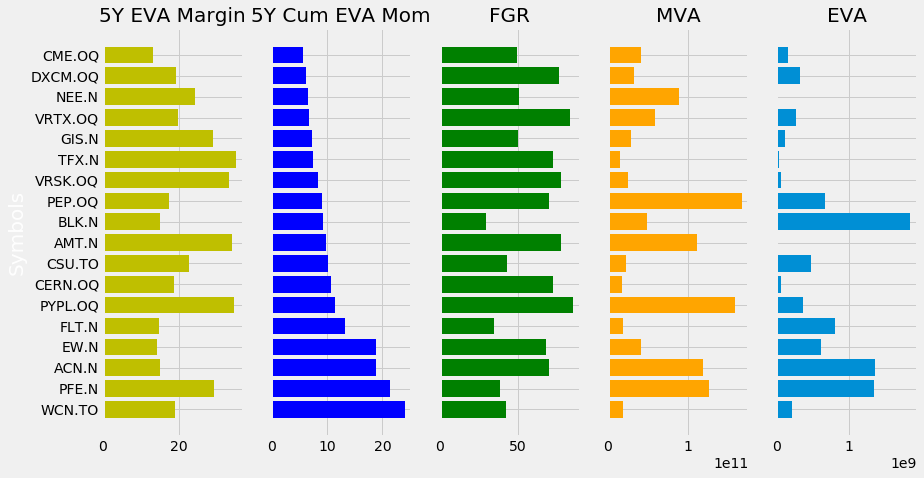

In [27]:
fig = plt.figure(figsize=(13,7))

ax1 = fig.add_subplot(1,5,1)
ax2 = fig.add_subplot(1,5,2)
ax3 = fig.add_subplot(1,5,3)
ax4 = fig.add_subplot(1,5,4)
ax5 = fig.add_subplot(1,5,5)

ax1.barh(Top_Pick['Instrument'],Top_Pick['5 Year Avg EVA Margin'],align='center',alpha=1,color='y')
ax1.set_yticks(Top_Pick['Instrument'])
ax1.set_ylabel('Symbols', color='white',size=20)
ax1.set_title('5Y EVA Margin',size='20')

ax2.barh(Top_Pick['Instrument'],Top_Pick['5 Year Cummulative EVA Momentum'],align='center',alpha=1,color='b')
ax2.set_title('5Y Cum EVA Mom',size=20)
ax2.tick_params(axis='y', colors='none')

ax3.barh(Top_Pick['Instrument'],Top_Pick['FGR'],align='center',alpha=1,color='g')
ax3.set_title('FGR',size=20)
ax3.tick_params(axis='y', colors='none')

ax4.barh(Top_Pick['Instrument'],Top_Pick['MVA'],align='center',alpha=1,color='orange')
ax4.set_title('MVA',size=20)
ax4.tick_params(axis='y', colors='none')

ax5.barh(Top_Pick['Instrument'],Top_Pick['EVA'],align='center',alpha=1)
ax5.set_title('EVA',size=20)
ax5.tick_params(axis='y', colors='none')

plt.show()

In [19]:
Top_Pick['Instrument']

725     WCN.TO
340      PFE.N
485      ACN.N
390       EW.N
193      FLT.N
372    PYPL.OQ
167    CERN.OQ
583     CSU.TO
371      AMT.N
170      BLK.N
168     PEP.OQ
370    VRSK.OQ
375      TFX.N
337      GIS.N
165    VRTX.OQ
211      NEE.N
166    DXCM.OQ
241     CME.OQ
Name: Instrument, dtype: object